In [1]:
import torch
import numpy as np
import cv2
from segment_anything import sam_model_registry, SamPredictor
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
image = cv2.imread("Syringe4.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [3]:
sam_checkpoint = "/Users/venkatasaisarangrandhe/sam_weights/sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [4]:
np.shape(image_rgb)

(3024, 4032, 3)

## Interactive Way to select the bounding box (Can be skipped)

In [5]:
bbox = cv2.selectROI("Select Bounding Box", image_rgb, fromCenter=False, showCrosshair=True)
cv2.destroyAllWindows()

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


In [6]:
x, y, w, h = bbox
x1, y1, x2, y2 = x, y, x + w, y + h

In [7]:
image_rgb = image_rgb[y1:y2, x1:x2]

## Or this cell

In [11]:
x1, y1, x2, y2 = 100, 1300, 4032, 1800  # Example bounding box for Syringe 4
image_rgb = image_rgb[y1:y2, x1:x2]

## Continue with these

In [8]:
x, y, z = np.shape(image_rgb)

In [9]:
predictor.set_image(image_rgb)

In [10]:

input_box = np.array([0, 0, y, x]) #Just the shape of the image

input_label = np.array([0]) 

In [11]:
masks, scores, logits = predictor.predict(
    box=input_box[None, :],
    multimask_output=False
)

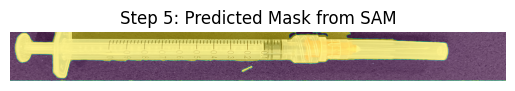

In [12]:
mask = masks[0]  # single mask from box
mask = ~mask  # Sometimes, segmentation takes the background as foreground. I am still looking to correct it automatically
plt.figure()
plt.imshow(image_rgb)
plt.imshow(mask, alpha=0.5)
plt.title("Step 5: Predicted Mask from SAM")
plt.axis('off')
plt.show()

In [13]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
cleaned_mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)

In [14]:
# Label connected components
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(cleaned_mask)

# Get the largest component (excluding background: label 0)
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
main_component_mask = (labels == largest_label).astype(np.uint8)

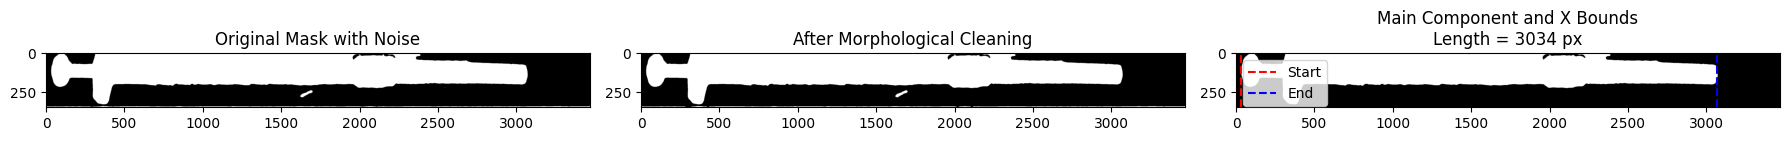

In [15]:
x_indices = np.any(main_component_mask, axis=0)
x_start = np.argmax(x_indices)
x_end = len(x_indices) - 1 - np.argmax(x_indices[::-1])
syringe_length = x_end - x_start

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(mask, cmap='gray')
axes[0].set_title('Original Mask with Noise')

axes[1].imshow(cleaned_mask, cmap='gray')
axes[1].set_title('After Morphological Cleaning')

axes[2].imshow(main_component_mask, cmap='gray')
axes[2].axvline(x_start, color='red', linestyle='--', label='Start')
axes[2].axvline(x_end, color='blue', linestyle='--', label='End')
axes[2].set_title(f'Main Component and X Bounds\nLength = {syringe_length} px')
axes[2].legend()

plt.tight_layout()
plt.show()

Max width column: 359
Max width value (pixels): 329


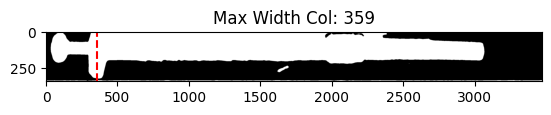

In [16]:

column_sums = np.sum(main_component_mask, axis=0)
max_width_col = np.argmax(column_sums)
max_width_value = column_sums[max_width_col]

print("Max width column:", max_width_col)
print("Max width value (pixels):", max_width_value)


plt.imshow(mask, cmap='gray')
plt.axvline(max_width_col, color='red', linestyle='--')
plt.title(f"Max Width Col: {max_width_col}")
plt.show()

In [17]:
x_foreground = np.any(mask, axis=0)           # Boolean array: columns with any mask
x_coords = np.where(x_foreground)[0]          # Column indices with mask
x_center = int(np.mean(x_coords))             # Mean column index

print("Mask x-center:", x_center)

Mask x-center: 1735


In [18]:
if max_width_col < x_center:
    orientation = "Needle is pointing RIGHT"
else:
    orientation = "Needle is pointing LEFT"

print("🟢", orientation)

🟢 Needle is pointing RIGHT


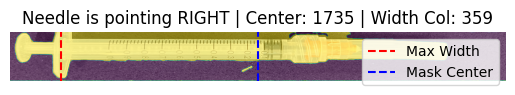

In [19]:
plt.imshow(image_rgb)
plt.imshow(mask, alpha=0.5)
plt.axvline(max_width_col, color='red', linestyle='--', label='Max Width')
plt.axvline(x_center, color='blue', linestyle='--', label='Mask Center')
plt.title(f"{orientation} | Center: {x_center} | Width Col: {max_width_col}")
plt.legend()
plt.axis('off')
plt.show()

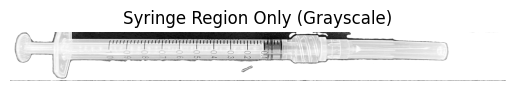

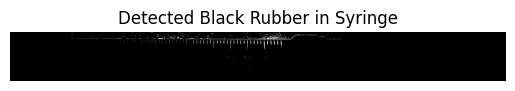

In [20]:
# Convert to grayscale
gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

# Apply mask to grayscale image
syringe_region = np.where(mask, gray, 255)  # Set non-syringe to white (255)

# Visualize
plt.imshow(syringe_region, cmap='gray')
plt.title("Syringe Region Only (Grayscale)")
plt.axis('off')
plt.show()

# Step: Find darkest areas (black rubber)
min_val = np.min(syringe_region)
black_threshold = min_val + 10  # Allow a small margin

# Create mask of black rubber
rubber_mask = syringe_region < black_threshold

# Visualize result
plt.imshow(rubber_mask, cmap='gray')
plt.title("Detected Black Rubber in Syringe")
plt.axis('off')
plt.show()

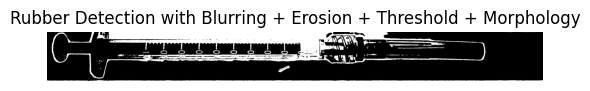

In [21]:
# Step 1: Contrast Stretching
syringe_enhanced = cv2.equalizeHist(syringe_region.astype(np.uint8))

kernel = np.ones((3, 3), np.uint8)
eroded = cv2.erode(syringe_enhanced, kernel, iterations=1)

# Step 2: Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(eroded, (3, 3), 0)

# Step 3: Erosion to remove small bright noise


# Step 4: Threshold to find darkest regions
_, rubber_mask = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY_INV)

# Step 5: Morphological cleanup (remove small holes)
rubber_mask = cv2.morphologyEx(rubber_mask, cv2.MORPH_OPEN, kernel)

# Step 6: Show the result
plt.imshow(rubber_mask, cmap='gray')
plt.title("Rubber Detection with Blurring + Erosion + Threshold + Morphology")
plt.axis('off')
plt.show()

Best region inside mask: 1823–1843, avg intensity = 251.31


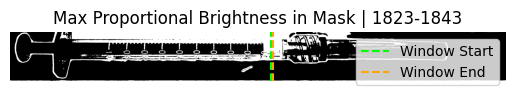

In [22]:


# Image size
height, width = rubber_mask.shape

# Sliding window config
window_size = 20
start_limit = int(0.25 * width)
end_limit = int(0.75 * width)

# Tracking best window
max_ratio = -1
best_start = -1

for col in range(start_limit, end_limit - window_size + 1):
    # Define the current window slice
    mask_window = mask[:, col:col + window_size]
    image_window = rubber_mask[:, col:col + window_size]

    # Extract only pixels within the mask
    valid_pixels = image_window[mask_window]

    if valid_pixels.size == 0:
        continue  # skip if no mask present

    ratio = np.mean(valid_pixels)  # or sum(valid_pixels)/count — same here
    if ratio > max_ratio:
        max_ratio = ratio
        best_start = col

# Result
start_col = best_start
end_col = best_start + window_size

print(f"Best region inside mask: {start_col}–{end_col}, avg intensity = {max_ratio:.2f}")

# Visualization
plt.imshow(rubber_mask, cmap='gray')
plt.axvline(start_col, color='lime', linestyle='--', label='Window Start')
plt.axvline(end_col, color='orange', linestyle='--', label='Window End')
plt.title(f"Max Proportional Brightness in Mask | {start_col}-{end_col}")
plt.legend()
plt.axis('off')
plt.show()

In [20]:
# Left to right or Right to left 